## Trading System Classes

In [1]:
class Trader():
    def __init__(self, stock_exchange, capital):
        self.initial_capital = capital
        self.cash = capital
        self.portfolio = {}
        self.exchange = stock_exchange
        self.transaction_fees = 0.002
        
    def buy(self, counter, size_to_buy):
        # checks if counter even exists
        if counter in self.exchange.get_available_counters():
            # enough cash?
            if self.exchange.get_price(counter) * size_to_buy <= self.cash:
                self.cash -= (self.exchange.get_price(counter) * size_to_buy * (1+self.transaction_fees))
                if counter not in self.portfolio.keys():
                    self.portfolio[counter] = size_to_buy
                else:
                    self.portfolio[counter] += size_to_buy
            else:
                raise ValueError('Not enough money')
            pass


    def sell(self, counter, size_to_sell):
        # checks if shares exists in trader's portfolio
        if counter in self.portfolio.keys():
            # enough shares?
            if size_to_sell > 0:
                if self.portfolio[counter] >= size_to_sell:
                    #print("Cash before:")
                    #print(self.cash)
                    self.portfolio[counter] -= size_to_sell
                    #print("Cash gotten:")
                    #print(self.exchange.get_price(counter) * size_to_sell * (1-self.transaction_fees))
                    self.cash += (self.exchange.get_price(counter) * size_to_sell * (1-self.transaction_fees))
                    #print("Cash now:")
                    #print(self.cash)
                else:
                    raise ValueError('Not enough shares to sell')
    def get_portfolio_value(self):
        value = self.cash;
        for i in self.portfolio.keys():
            value = value + (self.portfolio[i] * self.exchange.get_price(i))
            #print('Date: ' + str(self.exchange.get_date()))
        return value
    
    def get_portfolio(self):
        return self.portfolio
    
    def get_max_stocks_purchasable(self, counter, funds):
        return math.floor(funds/((1+self.transaction_fees) * self.exchange.get_price(counter)))
    
    def get_cash(self):
        return self.cash
    
    def get_initial_capital(self):
        return self.initial_capital
    
    def get_profits(self):
        return self.get_portfolio_value() - self.get_initial_capital()
    
    @staticmethod
    def copy(trader):
        new_trader = Trader(trader.exchange, trader.get_initial_capital())
        new_trader.cash = trader.get_cash()
        
        if stock_symbol in trader.get_portfolio().keys():
            new_trader.portfolio = { stock_symbol : trader.get_portfolio()[stock_symbol]}
        else:
            new_trader.portfolio = {}
        new_trader.transaction_fees = 0.00175#0.002
        return new_trader
            
class Stock_Exchange():
    def __init__(self, counters):
        self.available_counters = counters # takes a list, ['aig', 'bac', 'c', 'googl_v3', 'gs', 'jpm']
        self.data = {}
        self.date = datetime.datetime.strptime('2000-01-01', "%Y-%m-%d").date()
        self.last_date = datetime.datetime.strptime('2020-01-01', "%Y-%m-%d").date()
        for i in self.available_counters:
            data = pd.read_csv('data/' + i + '.csv')
            data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
            self.data[i] = data
            if(self.date < self.data[i]["Date"][0]):
                self.date = self.data[i]["Date"][0]
                
            if(self.last_date > self.data[i]["Date"].iloc[-1]):
                self.last_date = self.data[i]["Date"].iloc[-1]
        
        self.first_date = self.date
        
    def get_available_counters(self):
        return self.available_counters
    
    def get_price(self, counter):
        if(counter in self.available_counters):
            #print(self.data)
            val = self.data[counter].loc[self.data[counter]['Date'] == self.date]['Close']
            return list(val)[0]
        else:
            raise ValueError('Counter does not exist in exchange')
            
    def set_date(self, date, date_format):
        date = datetime.datetime.strptime(date, date_format).date()
        self.date = date
        
    def set_date(self, date):
        self.date = date
    
    def get_date(self):
        return self.date
            
    def next_day(self):
        self.date = self.date + datetime.timedelta(days=1)
        repeat = True
        while repeat:
            repeat = False
            '''for i in self.available_counters:
                if not (self.data[i]['Date'] == self.date).any():
                    #print(self.date)
                    #print('is a weekend')
                    self.date = self.date + datetime.timedelta(days=1)
                    repeat = True
                    break
            '''
            if self.date.weekday() >= 5:
                self.date = self.date + datetime.timedelta(days=1)
                repeat = True
    def get_last_date(self):
        return self.last_date
    
    def get_first_date(self):
        return self.first_date
    
    def reset(self):
        self.date = self.first_date
    
    def fast_forward(self):
        self.date = self.last_date

## Helper Methods

In [2]:
def get_processed_data(technical_indicated_file):
    std_span = 10
    # Data reading and preprocessing
    data =  pd.read_csv(technical_indicated_file)
    data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
    small_data = data
    x = small_data['Date']

    # Calculating std (sigma)
    std = pd.DataFrame()
    std['Date'] = small_data['Date']
    std['Rolling-STD'] = small_data["EMA-12-Close"].rolling(std_span).std()
    
    # PCT_CHANGE
    small_data['Pct_Change'] = small_data['EMA-12-Close'].pct_change()
    small_data['Abs_Pct_Change'] = abs(small_data['EMA-12-Close'].pct_change())
    small_data['Pct_Change_Vol'] = small_data['EMA-12-Volume'].pct_change()
    
    """
    Calculating volatility
    """
    crashes_k = pd.DataFrame()
    crashes_k["Date"] = small_data["Date"]
    crashes_k["crashes_k"] = small_data['neg_and_above_threshold'] * 1


    """ 
    Using PPO for Timing
    """
    # neg_k = 1 when trigger goes on top of PPO line (Red)
    # pos_k = 1 when trigger goes below PPO line (Green)

    d = (small_data["PPO"] - small_data["PPO-EMA-Trigger"])

    # PPO Buy and Sell Signals
    ppo_above = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    ppo_below = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    ppo_buy_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    ppo_sell_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))


    d = (small_data["PPO"] - small_data["PPO-EMA-Trigger"])
    for i in range(1, len(d) - 1):
        if d[i] * d[i - 1] < 0.:
            # crossover at i
            if(d[i] > 0.):
                ppo_above[i] = small_data.loc[i, "PPO-EMA-Trigger"]
                ppo_buy_signals[i] = small_data.loc[i, "Date"]
            else:
                ppo_below[i] = small_data.loc[i, "PPO-EMA-Trigger"]
                ppo_sell_signals[i] = small_data.loc[i, "Date"]

    #ppo_buy_signals.to_csv(folder + counter + "-ppo-buy.csv", index=False)
    #ppo_sell_signals.to_csv(folder + counter + "-ppo-sell.csv", index=False)


    # Caclulating ppo_k
    ppo_k = pd.DataFrame()

    # Populating std
    ppo_k['std'] = std['Rolling-STD']

    # Filling pos_k and neg_k with 1
    ppo_k["Date"] = small_data["Date"]
    ppo_k["pos_k"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["pos_k"].loc[ppo_k["Date"] == ppo_buy_signals] = 1

    ppo_k["neg_k"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["neg_k"].loc[ppo_k["Date"] == ppo_sell_signals] = 1
    assert(all(std["Date"] == ppo_k["Date"]))

    # Filling ppo_k dataframe with t to help speed up calculation during half-life
    # Init t as 0 for dates where ppo signals
    ppo_k["pos_k_t"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["pos_k_t"].loc[ppo_k["pos_k"] == 1] = 0

    ppo_k["neg_k_t"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["neg_k_t"].loc[ppo_k["neg_k"] == 1] = 0

    # Identify first pos_k and first neg_k
    first_pos_k_index = ppo_k['pos_k'].idxmax()
    first_neg_k_index = ppo_k['neg_k'].idxmax()

    # Populating ppo t values 
    tmp = ppo_k.copy()
    i = 0
    while ppo_k["pos_k_t"][first_pos_k_index:].isnull().values.any() or ppo_k["neg_k_t"][first_neg_k_index:].isnull().values.any():
        i+=1
        tmp = tmp.shift()
        ppo_k["pos_k_t"].loc[(tmp["pos_k"] == 1) & (ppo_k["pos_k_t"].isnull())] = i
        ppo_k["neg_k_t"].loc[(tmp["neg_k"] == 1) & (ppo_k["neg_k_t"].isnull())] = i


    """
    Using RSI for Timing
    """
    # neg_k = 1 when above 70 (Overbought)
    # pos_k = 1 when above 30 (Oversold)
    overbought = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    oversold = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    rsi_buy_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    rsi_sell_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))

    d_overbought = (70 - small_data["RSI"])
    for i in range(1, len(d_overbought) - 1):
        '''if d_overbought[i] * d_overbought[i - 1] < 0.:
                # crossover at i
                if d_overbought[i] < 0.:
                    rsi_sell_signals[i] = small_data.loc[i, "Date"]
                    overbought[i] = 70 #small_data.loc[i, "RSI"]'''
        if(d_overbought[i] < 0):
            rsi_sell_signals[i] = small_data.loc[i, "Date"]




    d_oversold = (30 - small_data["RSI"])
    for i in range(1, len(d_oversold) - 1):
        '''if d_oversold[i] * d_oversold[i - 1] < 0.:
                # crossover at i
                if d_oversold[i] > 0.:
                    rsi_buy_signals[i] = small_data.loc[i, "Date"]
                    oversold[i] = 30 #small_data.loc[i, "RSI"]'''
        if(d_oversold[i] > 0):
            rsi_buy_signals[i] = small_data.loc[i, "Date"]



    # Caclulating rsi_k
    rsi_k = pd.DataFrame()

    # Populating std
    rsi_k['std'] = std['Rolling-STD']

    # Filling pos_k and neg_k with 1
    rsi_k["Date"] = small_data["Date"]
    rsi_k["pos_k"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["pos_k"].loc[rsi_k["Date"] == rsi_buy_signals] = 1

    rsi_k["neg_k"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["neg_k"].loc[rsi_k["Date"] == rsi_sell_signals] = 1
    assert(all(std["Date"] == rsi_k["Date"]))


    # Filling rsi_k dataframe with t to help speed up calculation during half-life
    # Init t as 0 for dates where rsi signals
    rsi_k["pos_k_t"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["pos_k_t"].loc[rsi_k["pos_k"] == 1] = 0

    rsi_k["neg_k_t"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["neg_k_t"].loc[rsi_k["neg_k"] == 1] = 0

    # Identify first pos_k and first neg_k
    first_pos_k_index = rsi_k['pos_k'].idxmax()
    first_neg_k_index = rsi_k['neg_k'].idxmax()

    # Populating rsi t values 
    tmp = rsi_k.copy()
    i = 0
    while rsi_k["pos_k_t"][first_pos_k_index:].isnull().values.any() or rsi_k["neg_k_t"][first_neg_k_index:].isnull().values.any():
        i+=1
        tmp = tmp.shift()
        rsi_k["pos_k_t"].loc[(tmp["pos_k"] == 1) & (rsi_k["pos_k_t"].isnull())] = i
        rsi_k["neg_k_t"].loc[(tmp["neg_k"] == 1) & (rsi_k["neg_k_t"].isnull())] = i
    
    return ppo_k, rsi_k, crashes_k, small_data, ppo_buy_signals, ppo_sell_signals

def get_combined_k(decay_alpha_ppo, decay_alpha_rsi, ppo_k, rsi_k, technical_data, crashes_k):
    """
    Generate combined pos_k and neg_k based on given decay_alpha
    """
    
    assert(len(ppo_k) == len(rsi_k) and len(technical_data) == len(crashes_k) and len(technical_data == len(ppo_k)))
    
    # Decay ppo_k using half-life 
    ppo_k["pos_k_hl"] = ppo_k["pos_k"]
    ppo_k["neg_k_hl"] = ppo_k["neg_k"]

    tmp = (-1 * decay_alpha_ppo * technical_data['Abs_Pct_Change'])
    
    ppo_k["pos_k_hl"] = (math.e ** (tmp * ppo_k["pos_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    ppo_k["neg_k_hl"] = (math.e ** (tmp * ppo_k["neg_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    
    '''ppo_k["pos_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_ppo * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * ppo_k["pos_k_t"])) 
    ppo_k["neg_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_ppo * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * ppo_k["neg_k_t"]))
    '''
    # Decay rsi_k using half-life 
    rsi_k["pos_k_hl"] = rsi_k["pos_k"]
    rsi_k["neg_k_hl"] = rsi_k["neg_k"]
    
    tmp = (-1 * decay_alpha_rsi * technical_data['Abs_Pct_Change'])

    rsi_k["pos_k_hl"] = (math.e ** (tmp * rsi_k["pos_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    rsi_k["neg_k_hl"] = (math.e ** (tmp * rsi_k["neg_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    
    '''rsi_k["pos_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_rsi * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * rsi_k["pos_k_t"])) 
    rsi_k["neg_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_rsi * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * rsi_k["neg_k_t"]))
    '''
    #print(rsi_k["pos_k_hl"])
    #rsi_k.to_csv(folder + counter + "-rsi.csv")
    #ppo_k.to_csv(folder + counter + "-ppo.csv")

    # Combining PPO_K and RSI_K
    assert(all(ppo_k["Date"] == rsi_k["Date"]) and all(ppo_k["Date"] == technical_data["Date"]) and all(crashes_k["Date"] == ppo_k["Date"]))
    
    combined_k = pd.DataFrame()
    combined_k["Date"] = technical_data["Date"]
    combined_k["pos_k_hl"] = ppo_k["pos_k_hl"].fillna(0) * rsi_k["pos_k_hl"].fillna(0)
    combined_k["neg_k_hl"] = pow(ppo_k["neg_k_hl"].fillna(0) * rsi_k["neg_k_hl"].fillna(0), 1-crashes_k["crashes_k"])
    #combined_k["neg_k_hl"] = ppo_k["neg_k_hl"].fillna(0) * rsi_k["neg_k_hl"].fillna(0)


    # Using ADX & DMI
    # Irrespective of whether the trader takes a long or short position, 
    # the ADX should be over 25 when the crossover occurs to confirm the trend’s strength. 
    combined_k["pos_k_hl_copy"] = combined_k["pos_k_hl"]
    combined_k["neg_k_hl_copy"] = combined_k["neg_k_hl"]

    assert(all(combined_k["Date"]==technical_data["Date"]))

    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 20)] = combined_k["neg_k_hl"] * 0.25
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 30)] = combined_k["neg_k_hl"] * 0.5
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["neg_k_hl"] * 1.0
    
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 20)] = combined_k["pos_k_hl"] * 0.25
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 30)] = combined_k["pos_k_hl"] * 0.5
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["pos_k_hl"] * 1.0
    
    # Make it mutually exlusive
    combined_k["neg_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] > 20)] = 0
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] < technical_data["NEG_DI14"]) & (technical_data["ADX"] > 20)] = 0

    # Trend not strong enough
    combined_k["neg_k_hl_copy"].loc[(technical_data["ADX"] < 20)] = 0
    combined_k["pos_k_hl_copy"].loc[(technical_data["ADX"] < 20)] = 0

    # combined_k.to_csv(folder + counter + "-combined.csv", index=False)
    return combined_k

def calculate_profit(a_trading_pattern):
    mock_trader = Trader(secondary_exchange, capital)
    trade(a_trading_pattern, mock_trader)
    return mock_trader.get_portfolio_value() - mock_trader.get_initial_capital()
    

def trade(a_trading_pattern, mock_trader):
    for index, row in a_trading_pattern.iterrows():
        secondary_exchange.set_date(row['Date'])
        if row['trading_action'] == ACTION_LONG:
            stocks_to_buy = mock_trader.get_max_stocks_purchasable(stock_symbol, mock_trader.get_cash())
            mock_trader.buy(stock_symbol, stocks_to_buy)
        elif row['trading_action'] == ACTION_CLOSE:
            if stock_symbol in mock_trader.get_portfolio().keys():
                mock_trader.sell(stock_symbol, mock_trader.get_portfolio()[stock_symbol])
                
def closest_k(k):
    closest_risk = None
    closest_distance = None
    for risk_level in risk_levels:
        distance = abs(k-risk_level)
        if closest_risk is None or distance < closest_distance:
            closest_distance = distance
            closest_risk = risk_level
    return closest_risk

def to_action(row):
    date = row['Date']
    risk_level = row['k']
    tmp_pattern = trading_patterns_dict[risk_level]
    return tmp_pattern[date]

In [3]:
import pandas as pd
import numpy as np
import datetime
import math
import copy
import matplotlib.pyplot as plt
import pickle
from collections import OrderedDict
from scipy.stats import spearmanr
from scipy.stats import pearsonr
%matplotlib inline

In [4]:

'''
PARAMETERS TO CHANGE
'''
stock_symbol = 'SPY'
window_size = 25 
get_optimal_values = False # This takes a long time...
generate_training_data = True
generate_test_data = False
to_resume = False

## RESUME function badly written. Please be understanding. Hahaha.
resume_from_window = 25 # will start from this window, minimum is window_size

start_price_indexes = [2125]#[25, 725, 1425] # this should be (25 + start_state_num from the risk_q_learning file)
if generate_test_data:
    start_price_indexes = [2125]
    
duration_for_each = 700 # this should be the same as the duration in risk_q_learning

''''''


assert(not (generate_training_data & generate_test_data)) # Can be both False

risk_levels = [-1, -0.5, -0.2, 0, 0.2, 0.5, 1]

ACTION_LONG = 0
ACTION_CLOSE = 1


assert(resume_from_window >= window_size)
trading_patterns_dir = './trading_patterns/'
training_data_dir = './training_data/'
trading_patterns = []
trading_patterns_dict = {}

dates = []
populated_dates = False
for level in risk_levels:    
    trading_patterns_dict[level] = {}
    
    for start_price_index in start_price_indexes:
        actions_data = pd.read_csv(trading_patterns_dir + stock_symbol + '_' + str(level) + '_' + str(start_price_index) + '_to_' + str(start_price_index + duration_for_each) + '.csv')
        actions_data['Date'] = actions_data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())

        for index, row in actions_data[start_price_index:start_price_index+duration_for_each].iterrows():
            trading_patterns_dict[level][row['Date']] = row['trading_action']
            if populated_dates is False:
                dates.append(row['Date'])
    populated_dates = True
exchange = Stock_Exchange([stock_symbol])
secondary_exchange = Stock_Exchange([stock_symbol])
capital = 10000

In [5]:
exchange.reset()
jingyang = Trader(exchange, capital)
folder = "./temp/"
ppo_k, rsi_k, crashes_k, technical_data, tmp_ppo_buy_dates, tmp_ppo_sell_dates = get_processed_data(folder+stock_symbol+'-technical-indicated.csv')

tmp_start_date = dates[0]
tmp_end_date = dates[-1]

start_date_index = technical_data.index[technical_data['Date'] == tmp_start_date].tolist()[0] 
end_date_index = technical_data.index[technical_data['Date'] == tmp_end_date].tolist()[0] 

truncated_ppo_k = ppo_k[start_date_index:end_date_index+1].reset_index(drop=True)
truncated_rsi_k = rsi_k[start_date_index:end_date_index+1].reset_index(drop=True)
truncated_crashes_k = crashes_k[start_date_index:end_date_index+1].reset_index(drop=True)
truncated_technical_data = technical_data[start_date_index:end_date_index+1].reset_index(drop=True)

c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Optimal parameters per window

In [6]:
# Training data production
resumed = False


if get_optimal_values:

    assert(len(truncated_ppo_k) % window_size == 0)

    start_regularizer = 1
    end_regularizer = 2

    training_data = {}
    training_data['window'] = []
    training_data['ppo'] = []
    training_data['rsi'] = []

    for k in range(0, 1): # for k in range(0, window_size) by right

        optimal_trader = Trader(secondary_exchange, capital)

        for i in range(k+window_size, len(truncated_ppo_k), window_size):
            
            if not resumed:
                if to_resume:
                    if i == resume_from_window:
                        training_data = pd.read_csv(training_data_dir+stock_symbol+'_optimal_parameters.csv').to_dict('list')
                        resumed = True
                        
                        if resume_from_window > window_size:
                            with open('saved_trader.pkl', 'rb') as input:
                                window_best_trader = pickle.load(input)
                                print(window_best_trader.get_profits())
                    
                else:
                    resumed = True
            if resumed:
                window_truncated_ppo_k = truncated_ppo_k[i:i+window_size]
                window_truncated_rsi_k = truncated_rsi_k[i:i+window_size]
                window_truncated_crashes_k = truncated_crashes_k[i:i+window_size]
                window_truncated_technical_data = truncated_technical_data[i:i+window_size]
                
                
                window_best_trader = None
                window_best_profits = None
                best_ppo = None
                best_rsi = None

                for multiplier_ppo in [1,8]:#range(start_regularizer, end_regularizer, 1):     
                    for multiplier_rsi in [1,8]:#range(start_regularizer, end_regularizer, 1): 

                        tmp_trader = Trader.copy(optimal_trader)
                        
                        combined_k = get_combined_k(decay_alpha_ppo=multiplier_ppo, decay_alpha_rsi=multiplier_rsi, ppo_k=window_truncated_ppo_k, rsi_k=window_truncated_rsi_k, technical_data=window_truncated_technical_data, crashes_k=window_truncated_crashes_k)
                        combined_k['k'] = 0
                        combined_k['k'].loc[combined_k['pos_k_hl_copy'] > combined_k['neg_k_hl_copy']] = combined_k['pos_k_hl_copy'] 
                        combined_k['k'].loc[combined_k['neg_k_hl_copy'] > combined_k['pos_k_hl_copy']] = -1 * combined_k['neg_k_hl_copy'] 

                        combined_k['k'] = combined_k['k'].apply(closest_k)
                        combined_k['trading_action'] = 0
                        combined_k['trading_action'] = combined_k.apply(to_action, axis=1)

                        trade(combined_k, tmp_trader)

                        profit = tmp_trader.get_profits()

                        if window_best_trader is None or profit > window_best_profits:
                            window_best_trader = tmp_trader
                            window_best_profits = profit
                            best_ppo = multiplier_ppo
                            best_rsi = multiplier_rsi


                        #print(stock_symbol + '- ppo_decay : ' + str(multiplier_ppo) + ', rsi_decay : ' + str(multiplier_rsi))    
                        #print(profit)

                training_data['window'].append(i-window_size+start_price_indexes[0]-25)
                training_data['ppo'].append(best_ppo)
                training_data['rsi'].append(best_rsi)
                print('best_ppo ' + str(best_ppo))
                print('best_rsi ' + str(best_rsi))
                print('best profit after window: ' + str(i-window_size+start_price_indexes[0]-25) + "/" + str(len(truncated_ppo_k)))
                print(window_best_trader.get_profits())
                print('cash:' + str(window_best_trader.get_cash()))
                print('stocks:' + str(window_best_trader.get_portfolio()))
                
                with open('saved_trader.pkl', 'wb') as output:
                    pickle.dump(window_best_trader, output, pickle.HIGHEST_PROTOCOL)

                
                print("If you stop here. Resume using resume_from_window=" + str(i+window_size+start_price_indexes[0]-25))
                optimal_trader = Trader.copy(window_best_trader)

                # Save results
                pd.DataFrame(training_data).to_csv(training_data_dir+stock_symbol+'_optimal_parameters.csv', index=False)

    

In [7]:
if generate_training_data or generate_test_data:
    
    features_dict = {}
    
    # What you want to use as features, and should correspond to technical_data's column names
    features = ['Pct_Change_Vol'] #['Pct_Change', 'Pct_Change_Vol'] #
    
    
    features_dict['Date_to_use_on'] = []
    
    for i in range(1, window_size+1):
        for features_i in features:
            features_dict[features_i+'_'+str(i)] = []
    
    if generate_test_data:
        
        for window in range(0, len(truncated_technical_data)-window_size):
            for i in range(window_size):
                index_to_retrieve = window + i
                
                for features_i in features:
                    features_dict[features_i+'_'+str(i+1)].append(truncated_technical_data[features_i][index_to_retrieve])
            
            features_dict['Date_to_use_on'].append(truncated_technical_data['Date'][window+window_size])
        test_data = pd.DataFrame(features_dict) 
        test_data.to_csv(training_data_dir+stock_symbol+'_test_data.csv', index=False)
        
    if generate_training_data:    
        features_dict['window'] = []
        optimal_parameters = pd.read_csv(training_data_dir + stock_symbol+'_optimal_parameters_test.csv')
        for index, row in optimal_parameters.iterrows():
            window = row['window']

            features_dict['window'].append(window)
            
            window = window - (start_price_indexes[0] - 25)
            for i in range(window_size):
                index_to_retrieve = window + i 

                for features_i in features:
                    features_dict[features_i+'_'+str(i+1)].append(truncated_technical_data[features_i][index_to_retrieve])
                    
            features_dict['Date_to_use_on'].append(truncated_technical_data['Date'][window+window_size])

        features_df = pd.DataFrame(features_dict)
        
        training_data = pd.merge(optimal_parameters, features_df)
        training_data.to_csv(training_data_dir+stock_symbol+'_training_data_test.csv', index=False)
    

## Verifcation

In [8]:
# Used if you only want to change optimal values every window_size
'''optimal = pd.read_csv('./training_data/' + stock_symbol + '_training_data.csv').sort_values('window').reset_index(drop=True)


for index, row in optimal.iterrows():
    if index%window_size == 0:
        ppo = row['ppo']
        rsi = row['rsi']
        print(index)
        for i in range(window_size):
            optimal['ppo'].loc[index+i] = ppo
            optimal['rsi'].loc[index+i] = rsi'''

"optimal = pd.read_csv('./training_data/' + stock_symbol + '_training_data.csv').sort_values('window').reset_index(drop=True)\n\n\nfor index, row in optimal.iterrows():\n    if index%window_size == 0:\n        ppo = row['ppo']\n        rsi = row['rsi']\n        print(index)\n        for i in range(window_size):\n            optimal['ppo'].loc[index+i] = ppo\n            optimal['rsi'].loc[index+i] = rsi"

In [9]:
optimal = pd.read_csv('./training_data/' + stock_symbol + '_training_data_tesT.csv').sort_values('window').reset_index(drop=True)

assert(len(truncated_technical_data)-window_size == len(optimal))


tmp_trader = Trader(secondary_exchange, capital)

#for i in range(window_size, len(truncated_ppo_k), window_size):
    
truntruncated_ppo_k = truncated_ppo_k[window_size:].reset_index(drop=True)
truntruncated_rsi_k = truncated_rsi_k[window_size:].reset_index(drop=True)
truntruncated_technical_data = truncated_technical_data[window_size:].reset_index(drop=True)
truntruncated_crashes_k = truncated_crashes_k[window_size:].reset_index(drop=True)

   
combined_k = get_combined_k(decay_alpha_ppo=optimal['ppo'], decay_alpha_rsi=optimal['rsi'], ppo_k=truntruncated_ppo_k, rsi_k=truntruncated_rsi_k, technical_data=truntruncated_technical_data, crashes_k=truntruncated_crashes_k)

combined_k['k'] = 0
combined_k['k'].loc[combined_k['pos_k_hl_copy'] > combined_k['neg_k_hl_copy']] = combined_k['pos_k_hl_copy'] 
combined_k['k'].loc[combined_k['neg_k_hl_copy'] > combined_k['pos_k_hl_copy']] = -1 * combined_k['neg_k_hl_copy'] 

combined_k['old_k'] = combined_k['k']  
combined_k['k'] = combined_k['k'].apply(closest_k)
combined_k['trading_action'] = 0
combined_k['trading_action'] = combined_k.apply(to_action, axis=1)


trade(combined_k, tmp_trader)
profit = tmp_trader.get_profits()
print(profit)
print((profit / tmp_trader.initial_capital) * 100)
    
#profit = calculate_profit(combined_k) # must be .loc
#print(profit)

c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


315.9932363059961
3.159932363059961


"ax3.plot(x,ppo_decay[start:end])\nax3.set_title('PPO Decay')\n# for date in ppo_buy:\n#     if(date in x.values):\n#         ax3.axvline(x=date, color='g', linestyle='-')\n# for date in ppo_sell:\n#     if(date in x.values):\n#         ax3.axvline(x=date, color='r', linestyle='-')\nax4.set_title('RSI Decay')\nax4.plot(x,rsi_decay[start:end])\n# for date in rsi_buy:\n#     if(date in x.values):\n#         ax4.axvline(x=date, color='g', linestyle='-')\n# for date in rsi_sell:\n#     if(date in x.values):\n#         ax4.axvline(x=date, color='r', linestyle='-')\n\nax5.plot(x,vol[start:end])\nax5.set_title('Volume')"

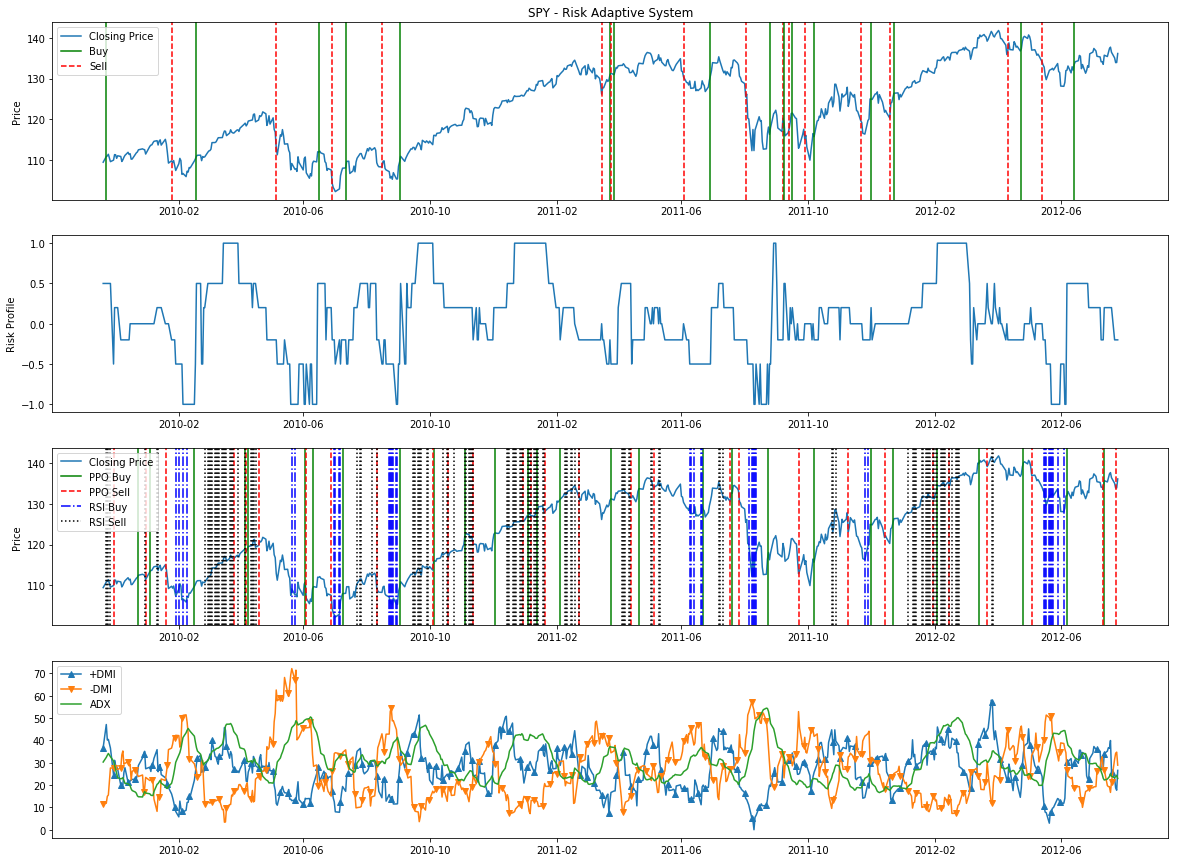

In [10]:
x = truntruncated_technical_data['Date']

y_1 = truntruncated_technical_data['Close']
y_2 = combined_k['k']
y_3 = combined_k['old_k']

y_p_dmi = truntruncated_technical_data['POS_DI14']
y_n_dmi = truntruncated_technical_data['NEG_DI14']
y_adx = truntruncated_technical_data["ADX"]

ppo_decay = optimal['ppo'] * truntruncated_technical_data['Abs_Pct_Change']
rsi_decay = optimal['rsi'] * truntruncated_technical_data['Abs_Pct_Change']
vol = truntruncated_technical_data['Volume']
vol_change =  abs(truntruncated_technical_data['Abs_Pct_Change'])

ppo_sell = truncated_ppo_k.loc[truncated_ppo_k['neg_k'] == 1]['Date'].values
ppo_buy = truncated_ppo_k.loc[truncated_ppo_k['pos_k'] == 1]['Date'].values
rsi_sell = truncated_rsi_k.loc[truncated_rsi_k['neg_k'] == 1]['Date'].values
rsi_buy = truncated_rsi_k.loc[truncated_rsi_k['pos_k'] == 1]['Date'].values

start = 0 #580 for aggresive, 750 for averse 
end = 700 #700 for aggressive, 900 for averse
x = x[start:end].values

'''fig=plt.figure(figsize=(15,5))
plt.plot(x,y_1[start:end])
plt.title(stock_symbol.upper() + ' - Risk Adaptive System')
bought = False
for index, row in combined_k.iterrows():
    if row['Date'] > x[0] and  row['Date'] < x[-1] and row['trading_action'] == ACTION_LONG and not bought:
        plt.axvline(row['Date'], color='g', linestyle='-', figure=fig, label= 'Buy Signal')
        bought = True
    if row['Date'] > x[0] and  row['Date'] < x[-1] and row['trading_action'] == ACTION_CLOSE and bought:
        plt.axvline(row['Date'], color='r', linestyle='-', figure=fig, label= 'Sell Signal')
        bought = False
        
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('Date')
plt.ylabel('Price')'''

fig=plt.figure(figsize=(20,15))
ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)


ax1.plot(x,y_1[start:end], label = 'Closing Price')
ax1.set_title(stock_symbol.upper() + ' - Risk Adaptive System')
bought = False
for index, row in combined_k.iterrows():
    if row['Date'] > x[0] and  row['Date'] < x[-1] and row['trading_action'] == ACTION_LONG and not bought:
        ax1.axvline(row['Date'], color='g', linestyle='-', label= 'Buy')
        bought = True
    if row['Date'] > x[0] and  row['Date'] < x[-1] and row['trading_action'] == ACTION_CLOSE and bought:
        ax1.axvline(row['Date'], color='r', linestyle='--', label= 'Sell')
        bought = False
        
        
handles, labels = ax1.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.set_ylabel('Price')
ax1.legend(by_label.values(), by_label.keys(), loc = 'upper left')


ax2.plot(x,y_2[start:end])
#ax2.set_title('Risk Profile')
ax2.set_ylabel('Risk Profile')

ax3.plot(x, y_1[start:end], label = 'Closing Price')
for i in ppo_buy:
    if i > x[0] and i < x[-1]:
        ax3.axvline(i, color='g', linestyle='-', label='PPO Buy')
for i in ppo_sell:
    if i > x[0] and i < x[-1]:
        ax3.axvline(i, color='r', linestyle='--', label='PPO Sell')

        
for i in rsi_buy:
    if i > x[0] and i < x[-1]:
        ax3.axvline(i, color='b', linestyle='-.', label='RSI Buy')
for i in rsi_sell:
    if i > x[0] and i < x[-1]:
        ax3.axvline(i, color='k', linestyle=':', label='RSI Sell')

                
handles, labels = ax3.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax3.set_ylabel('Price')
ax3.legend(by_label.values(), by_label.keys(), loc='upper left')

ax4.plot(x, y_p_dmi[start:end], marker='^', markevery=5, label="+DMI")
ax4.plot(x, y_n_dmi[start:end], marker='v', markevery=5, label="-DMI")
ax4.plot(x, y_adx[start:end], label="ADX")
ax4.legend(loc="upper left")

'''ax3.plot(x,ppo_decay[start:end])
ax3.set_title('PPO Decay')
# for date in ppo_buy:
#     if(date in x.values):
#         ax3.axvline(x=date, color='g', linestyle='-')
# for date in ppo_sell:
#     if(date in x.values):
#         ax3.axvline(x=date, color='r', linestyle='-')
ax4.set_title('RSI Decay')
ax4.plot(x,rsi_decay[start:end])
# for date in rsi_buy:
#     if(date in x.values):
#         ax4.axvline(x=date, color='g', linestyle='-')
# for date in rsi_sell:
#     if(date in x.values):
#         ax4.axvline(x=date, color='r', linestyle='-')

ax5.plot(x,vol[start:end])
ax5.set_title('Volume')'''

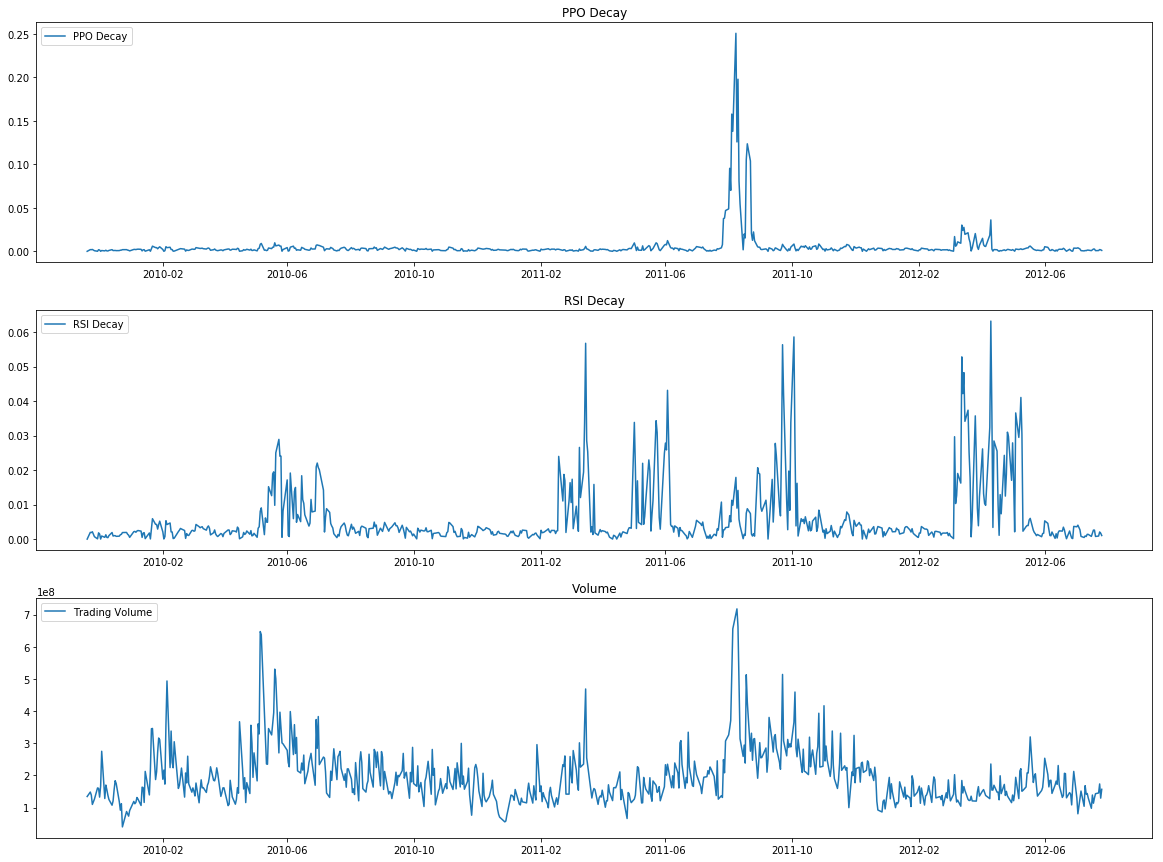

In [11]:
start = 0 
end = 700

x = truntruncated_technical_data['Date']
x = x[start:end].values

fig=plt.figure(figsize=(20,15))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.set_title('PPO Decay')
ax1.plot(x,ppo_decay[start:end], label="PPO Decay")
ax1.legend(loc='upper left')


ax2.set_title('RSI Decay')
ax2.plot(x,rsi_decay[start:end], label="RSI Decay")
ax2.legend(loc='upper left')

ax3.plot(x,vol[start:end], label="Trading Volume")
ax3.set_title('Volume')
ax3.legend(loc='upper left')

In [12]:
# Calculating Pearson's Correlation Coefficient

x_rsi = rsi_decay[start:end] 
x_ppo = ppo_decay[start:end]
y = vol[start:end]
print(stock_symbol)
print('ppo coeff:' + str(spearmanr(ppo_decay[start:end],vol[start:end])))
print('rsi coeff:' + str(spearmanr(rsi_decay[start:end],vol[start:end])))

print('ppo coeff:' + str(pearsonr(ppo_decay[start:end],vol[start:end])))
print('rsi coeff:' + str(pearsonr(rsi_decay[start:end],vol[start:end])))

SPY
ppo coeff:SpearmanrResult(correlation=0.22616937552796945, pvalue=2.810012463375627e-09)
rsi coeff:SpearmanrResult(correlation=0.24938052234103364, pvalue=4.9916577912411353e-11)
ppo coeff:(0.5115979399826114, 2.6976310377016528e-46)
rsi coeff:(0.23969789075503314, 2.823372539838576e-10)
